In [ ]:
"""
* 주제 : 와인종류 분류하기
* 사용데이터 : 08_wine.csv

<분석방법>
 - 스케일링 : 모든 스케일러 방식 사용
 - 데이터분류 : 훈련:검증:테스트 = 6 : 2 : 2로 분류하여 사용
 - 튜닝 없이 전체 모델 훈련하여 ~ 평가까지..
 - 하이퍼파라메터 튜닝 후 전체 모델 훈련하여 ~ 평가까지..


<모델별 하이퍼파라메터 변수들>
 * 랜덤포레스트, 엑스트라트리, 그레디언트부스트
  - n_estimators = [50, 100]
    : 트리 갯수 지정(보통 50~1000 사이값 사용)
  - max_depth = [None, 10]
    : 트리가 뻗어나가는 최대깊이 지정(None은 제한없음, 보통 3~10 사이값 사용)
  - min_samples_split = [2, 5]
    : 노드를 분할하기 위한 최소한의 샘플 수 (보통 2~10 사이값 사용)
  - min_samples_leaf = [1, 2, 4]
    : 리프노드(결정노드)의 최소한의 샘플 수 (보통 1~10 사이값 사용)


 * 히스트그레디언트부스트
  - max_iter = [50, 100]
    : 트리 갯수 지정(보통 50~1000 사이값 사용)
  - max_depth = [None, 10]
    : 트리가 뻗어나가는 최대깊이 지정(None은 제한없음, 보통 3~10 사이값 사용)
  - min_samples_leaf = [1, 2, 4]
    : 리프노드(결정노드)의 최소한의 샘플 수 (보통 1~10 사이값 사용)


 * 엑스지부스트
  - n_estimators = [50, 100]
    : 트리 갯수 지정(보통 50~1000 사이값 사용)
  - max_depth = [None, 10]
    : 트리가 뻗어나가는 최대깊이 지정(None은 제한없음, 보통 3~10 사이값 사용)
  - min_child_weight = [1, 2, 4]
    : 리프노드(결정노드)의 최소한의 샘플 수 (보통 1~10 사이값 사용)


<튜닝 자동화 모델(GridSearchCV 클래스)에서 사용할 튜닝 속성>
 * scoring = 정확도 사용("accuracy")
    : 튜닝 자동화 모델(클래스)에 사용할 평가 방법 지정
    : 분류에서는 정확도를 이용


 * refit = 정확도 사용("accuracy")
    : 튜닝 자동화 모델(클래스)에 사용할 모델 선정 기준 지정
    : scoring에서 한가지만 사용되기에 생략가능


 * cv = 5
    : 튜닝 자동화 모델(클래스)에 사용할 "교차검증" 시 사용할 Fold 갯수
    : Fold(폴드) -> 모델 훈련시 사용할 훈련데이터를 내부적으로
                -> 폴드의 갯수만큼 다시 분류(훈련:검증으로)하여 사용하는 방법


<해석>
 * 모든 처리 과정 각각에 대해서 해석 작성

<최종 결과>
 * 데이터프레임에 아래 항목 저장하여 비교 후 모델 선정 (튜닝 전과 후로 각각 진행)
  - 모델명, 훈련정확도, 검증정확도, (훈련-검증)정확도, 정밀도, 재현율, F1-Score
 * 모델 선정 후, 테스트 데이터로 최종 예측 진행 (최종 선정 모델로 한번 진행)

<개별 제출>
 - 구글드라이브에 제출
 - 제출 파일명 : 0조_이름_앙상블전체훈련및평가.ipynb
"""

In [72]:


import pandas as pd
### 숫자 데이터 처리 
import numpy as np

### 파이썬에서 가장 기본적으로 사용하는 시각화 라이브러리
import matplotlib.pyplot as plt

### 히트맵 라이브러리
import seaborn as sns

### 한글처리(시각화 시 그래프 내에 한글이 포함되는 경우 한글 깨짐 현상 방지)
plt.rc("font", family="Malgun Gothic")

### 특수기호(마이너스 기호) 처리
plt.rcParams["axes.unicode_minus"] = False

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures # 다항회귀 모델
from sklearn.ensemble import RandomForestClassifier # 랜덤 포레스트 분류 모델

### 앙상블 모델들....
# - 랜덤포레스트(회귀/분류 모두 가능한 모델)
from sklearn.ensemble import RandomForestClassifier
# - 엑스트라트리(회귀/분류 모두 가능한 모델)
from sklearn.ensemble import ExtraTreesClassifier
# - 그레디언트부스팅(회귀/분류 모두 가능한 모델)
from sklearn.ensemble import GradientBoostingClassifier
# - 히스트그레디언트부스팅(회귀/분류 모두 가능한 모델)
from sklearn.ensemble import HistGradientBoostingClassifier
# - 엑스지부스트(회귀/분류 모두 가능한 모델) = 히스트그레디언트부스팅과 동급(성능이 비슷함)
from xgboost import XGBClassifier


from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# confusion matrix 시각화 및 보고서 생성을 위한 라이브러리
from sklearn.metrics import ConfusionMatrixDisplay,classification_report, confusion_matrix 
# Cloassifier 평가 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score




In [52]:
df_wine = pd.read_csv("./data/08_wine.csv", encoding="utf-8")
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [53]:
# 1차 분할: train(60%), temp(40%)
train_input, temp_input, train_target, temp_target = train_test_split(
    df_wine.iloc[:, :-1], df_wine.iloc[:, -1], test_size=0.4, random_state=42
)
# 2차 분할: temp을 val(20%), test(20%)로 분할
val_input, test_input, val_target, test_target = train_test_split(
    temp_input, temp_target, test_size=0.5, random_state=42
)

In [54]:
rf = RandomForestClassifier(random_state=42)
rf.fit(train_input, train_target)

train_score = rf.score(train_input, train_target)
val_score = rf.score(val_input, val_target)
test_score = rf.score(test_input, test_target)

print(f"훈련 정확도 : {train_score:.4f}, 검증 정확도 : {val_score:.4f}, 테스트 정확도 : {test_score:.4f}")

훈련 정확도 : 0.9974, 검증 정확도 : 0.8845, 테스트 정확도 : 0.8731


In [55]:
def scaler_process(scaler, train_input, val_input, test_input):
    scaler.fit(train_input)
    return scaler.transform(train_input), scaler.transform(val_input), scaler.transform(test_input)
dict_scaler = {sc.__class__.__name__[:-6].lower(): scaler_process(sc, train_input, val_input, test_input) for sc in [StandardScaler(), MinMaxScaler(), RobustScaler()]}
dict_models = {}
for key in dict_scaler.keys():
    rf = RandomForestClassifier(random_state=42).fit(dict_scaler[key][0], train_target)
    dict_models[key] = rf
    
    print(f'Scaler: {key}')
    train_score = rf.score(dict_scaler[key][0], train_target)
    val_score   = rf.score(dict_scaler[key][1], val_target)
    test_score   = rf.score(dict_scaler[key][2], test_target)
    print(f'Train Score: {train_score:.3f}, Val Score: {val_score:.3f}, Test Score: {test_score:.3f}, Overfitting: {(train_score > test_score)}')
dict_models

Scaler: standard
Train Score: 0.997, Val Score: 0.886, Test Score: 0.875, Overfitting: True
Scaler: minmax
Train Score: 0.997, Val Score: 0.885, Test Score: 0.871, Overfitting: True
Scaler: robust
Train Score: 0.997, Val Score: 0.886, Test Score: 0.870, Overfitting: True


{'standard': RandomForestClassifier(random_state=42),
 'minmax': RandomForestClassifier(random_state=42),
 'robust': RandomForestClassifier(random_state=42)}

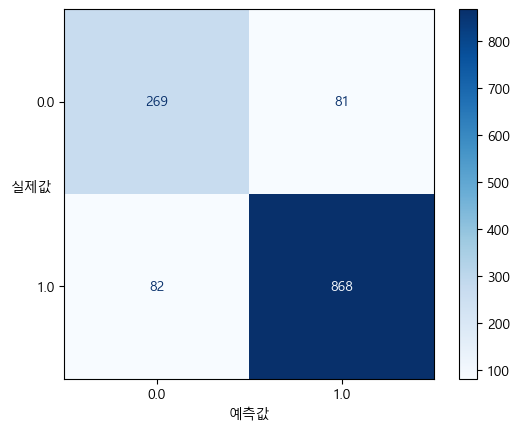

In [56]:
model = dict_models['standard'] # 스케일러별 모델 선택
model

cm = confusion_matrix(test_target, model.predict(dict_scaler['standard'][2]))

dist = ConfusionMatrixDisplay(cm, display_labels=model.classes_).plot(cmap=plt.cm.Blues)
plt.xlabel('예측값')
plt.ylabel('실제값',rotation=0)
dist

In [57]:

model_list = [
    RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=42),
    ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=42),
    GradientBoostingClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2, random_state=42),
    HistGradientBoostingClassifier(max_iter=100, max_depth=None, min_samples_leaf=1, random_state=42),
    XGBClassifier(n_estimators=100, max_depth=None, min_child_weight=1, random_state=42)
]
train_scaler = dict_scaler['standard'][0]
val_scaler = dict_scaler['standard'][1]
test_scaler = dict_scaler['standard'][2]

for m in model_list :
    # print(m.__class__.__name__)
    ### 모델 생성------------------
    model = m

    ### 모델 훈련 시키기------------------
    model.fit(train_scaler, train_target)

    ### 정확도(결정계수) 확인------------------
    # - 훈련 결정계수
    train_score = model.score(train_scaler, train_target)
    # - 검증 결정계수
    val_score   = model.score(val_scaler, val_target)
    # - 과적합여부
    minus = train_score - val_score

    ### 예측하기------------------
    # - 훈련 예측
    train_pred = model.predict(train_scaler)
    # - 검증 예측
    val_pred   = model.predict(val_scaler)
    # - 테스트 예측
    test_pred  = model.predict(test_scaler)
    print(f'\nModel: {m.__class__.__name__}')
    print(f"Train_score:{train_score:.3f} Val Score: {val_score:.3f}, Test Score: {model.score(test_scaler, test_target):.3f}")
    print(f'Train Prediction: {train_pred}, Val Prediction: {val_pred}, Test Prediction: {test_pred}')

    acc = accuracy_score(test_target, test_pred) # accuracy
    prec = precision_score(test_target, test_pred) # precision
    rec = recall_score(test_target, test_pred) # recall rate
    f1 = f1_score(test_target, test_pred) # f1-score
    print(f"Train Score : {train_score:<.3f}\nAccuracy: {acc:.3f}\
    Precision: {prec:.3f} \nRecall: {rec:.3f} \t   F1 Score: {f1:.3f}")



Model: RandomForestClassifier
Train_score:0.961 Val Score: 0.878, Test Score: 0.867
Train Prediction: [1. 1. 1. ... 1. 1. 0.], Val Prediction: [0. 1. 1. ... 1. 0. 1.], Test Prediction: [1. 0. 0. ... 0. 0. 1.]
Train Score : 0.961
Accuracy: 0.867    Precision: 0.910 
Recall: 0.907 	   F1 Score: 0.909

Model: ExtraTreesClassifier
Train_score:0.765 Val Score: 0.750, Test Score: 0.732
Train Prediction: [1. 1. 1. ... 1. 1. 1.], Val Prediction: [1. 1. 1. ... 1. 1. 1.], Test Prediction: [1. 1. 1. ... 1. 1. 1.]
Train Score : 0.765
Accuracy: 0.732    Precision: 0.732 
Recall: 1.000 	   F1 Score: 0.845

Model: GradientBoostingClassifier
Train_score:0.997 Val Score: 0.876, Test Score: 0.870
Train Prediction: [1. 1. 1. ... 1. 1. 0.], Val Prediction: [0. 1. 1. ... 0. 0. 1.], Test Prediction: [1. 0. 0. ... 0. 0. 1.]
Train Score : 0.997
Accuracy: 0.870    Precision: 0.916 
Recall: 0.905 	   F1 Score: 0.911

Model: HistGradientBoostingClassifier
Train_score:0.957 Val Score: 0.878, Test Score: 0.861
Tr

In [32]:
from sklearn.model_selection import GridSearchCV

In [58]:
gridParams = {}
### 랜덤포레스트 모델에서 훈련에 사용할 하이퍼파라메터 중 "트리의 갯수" 범위 지정
# - 앙상블 모델들은 -> 트리 모델을 여러개 모아 놓은 모델들이라고 해서 앙상블 모델이라고 칭합니다.
# - 통상적으로 사용하는 범위 : 10 ~ 1000 사이의 범위로 보통 50단위, 100단위, 500 단위로 주로 범위 지정
#                         : 값이 커질 수록 PC 자원에 따라 시간이 많이 소요 됩니다.
gridParams["n_estimators"] = [50, 100]
### 랜덤포레스트 모델에서 훈련 시에 트리가 밑으로 뻗어나가는 "최대 깊이" 범위 지정
# - None 깊이의 제한을 두지 않음(훈련 모델이 알아서 끝냄)
# - 최대 깊이를 지정했더라도, 모델이 더이상 훈련이 필요없는 경우에는 사전에 훈련이 종료 될 수도 있음
gridParams["max_depth"] = [None, 3, 10]


scoring = ["neg_mean_squared_error", "r2"]
### 모델 선정 기준 정의하기 : 평가 결고 중에 선정 기준으로 사용할 평가 방법 지정
# - 회귀에서는 r2(결정계수) 사용
refit = "r2"

### GridSearchCV 튜닝 모델에서 교차검증에 사용할 그룹(Fold)의 갯수 지정
# - 3 또는 5 (홀수 값 사용)
cv = 5

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 3, ...], 'n_estimators': [50, 100]}"
,scoring,"['neg_mean_squared_error', 'r2']"
,n_jobs,None
,refit,'r2'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


In [59]:
poly = PolynomialFeatures().fit(dict_scaler['standard'][0])
train_poly = poly.transform(dict_scaler['standard'][0])
val_poly   = poly.transform(dict_scaler['standard'][1])
test_poly  = poly.transform(dict_scaler['standard'][2])

print(train_input.shape, val_input.shape, test_input.shape)
print(train_poly.shape, val_poly.shape, test_poly.shape)

(3898, 3) (1299, 3) (1300, 3)
(3898, 10) (1299, 10) (1300, 10)


In [81]:
grid_search_model = GridSearchCV(
    ### 튜닝에 사용할 실제 모델 정의하기
    estimator=rf,
    ### 위에서 설정한 하이퍼파라메터 딕셔너리 변수 정의
    param_grid=gridParams,
    ### 모델 평가 방법 정의
    scoring=scoring,
    ### 모델 선정 기준 정의
    refit=refit,
    ### 교차검증(CV)에 사용할 Fold 갯수 지정
    cv=cv,
    ### CPU-Core 갯수 정의
)

############ 훈련 시키기
grid_search_model.fit(train_poly, train_target)

grid_search_model

,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [None, 10], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5], 'n_estimators': [50, 100]}"
,scoring,"['neg_mean_squared_error', 'r2']"
,n_jobs,None
,refit,'r2'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


In [37]:
### 최적의 하이퍼파라메터 확인하기
best_params = grid_search_model.best_params_
print(best_params)

### 최적의 결정계수값
best_score = grid_search_model.best_score_
print(f"{best_score:.4f}")

### 최적의 모델
# - 최적의 모델을 이용해서 검증/테스트 데이터로 예측 및 최종 평가를 수행하면 됩니다.
# - 평가 후 best 모델의 결정계수값과 훈련/검증/테스트의 결정계수값과 비교(과적합 여부 확인)
best_model = grid_search_model.best_estimator_
print(best_model)

{'max_depth': None, 'n_estimators': 50}
0.4014
RandomForestClassifier(n_estimators=50, random_state=42)


In [ ]:
df_model = pd.DataFrame()

### 튜닝된 모든 모델 저장하기 위한 리스트
result_model = []

### 모델에 사용된 스케일러를 저장할 리스트
result_scaler = []

# Best Model로 예측하기

scaler =StandardScaler()
scaler.fit(train_input)
train_scaled = scaler.transform(train_input)
val_scaled = scaler.transform(val_input)
test_scaled = scaler.transform(test_input)

params_1 = {"n_estimators" : [50, 100], 
            "max_depth" : [None, 10],
            "min_samples_split" : [2, 5],
            "min_samples_leaf" : [1, 2, 4]}

params_2 = {"max_iter" : [50, 100], 
            "max_depth" : [None, 10],
            "min_samples_leaf" : [1, 2, 4]}

params_3 = {"n_estimators" : [50, 100], 
            "max_depth" : [None, 10],
            "min_samples_leaf" : [1, 2, 4]}

model_list = [
    RandomForestClassifier(random_state=42),
    ExtraTreesClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42),
    HistGradientBoostingClassifier(random_state=42),
    XGBClassifier(random_state=42)
 ]
# train_poly = scaler.transform(dict_scaler['standard'][0])
# val_poly = scaler.transform(dict_scaler['standard'][1])
# test_poly = poly.transform(dict_scaler['standard'][2])

for m in model_list :
    model = m
    gridParams = {}

    print(m.__class__.__name__)
    if m.__class__.__name__ in ["RandomForestClassifier", "ExtraTreesClassifier", "GradientBoostingClassifier"] :
        gridParams = params_1
    elif m.__class__.__name__ in ["HistGradientBoostingClassifier"] :
        gridParams = params_2
    else:
        gridParams = params_3            
 
    grid_search = GridSearchCV(
    estimator=model,
    param_grid=gridParams,
    scoring="accuracy",
    refit="accuracy",
    cv=5,
    )
    grid_search.fit(train_scaled, train_target)

    model = grid_search.best_estimator_
    train_score = model.score(train_scaled, train_target)
    val_score   = model.score(val_scaled, val_target)
    minus = train_score - val_score

    train_pred = model.predict(train_scaled)
    # - 검증 예측
    val_pred   = model.predict(val_scaled)
    # - 테스트 예측
    test_pred  = model.predict(test_scaled)
    acc = accuracy_score(test_target, test_pred) # accuracy
    prec = precision_score(test_target, test_pred) # precision
    rec = recall_score(test_target, test_pred) # recall rate
    f1 = f1_score(test_target, test_pred) # f1-score
    
    df_model = pd.concat([df_model, pd.DataFrame({
        'Model': m.__class__.__name__,
        'Scaler' : 'StandardScaler',
        'Train Score': train_score,
        'Val Score': val_score,
        'Test Score': model.score(test_scaled, test_target),
        'Train Prediction': [train_pred],
        'Val Prediction': [val_pred],
        'Test Prediction': [test_pred],
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })], ignore_index=True)

df_model.loc[:, ['Model', 'Scaler', 'Train Score', 'Val Score', 'Test Score', 'Accuracy', 'Precision', 'Recall', 'F1 Score']].sort_values(by=['F1 Score','Train Score'], ascending=[False,False])

RandomForestClassifier
ExtraTreesClassifier
GradientBoostingClassifier
HistGradientBoostingClassifier
XGBClassifier


c:\ProgramData\anaconda3\envs\busan_base\lib\site-packages\xgboost\training.py:183: UserWarning: [17:42:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\envs\busan_base\lib\site-packages\xgboost\training.py:183: UserWarning: [17:42:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\envs\busan_base\lib\site-packages\xgboost\training.py:183: UserWarning: [17:42:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\ProgramData\anaconda3\envs\busan_base\lib\site-packages\xgboost\training.py:183: UserWarning: [17:42:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parame

,Model,Scaler,Train Score,Val Score,Test Score,Accuracy,Precision,Recall,F1 Score
0,RandomForestClassifier,StandardScaler,0.997435,0.886066,0.874615,0.874615,0.914647,0.913684,0.914165
1,ExtraTreesClassifier,StandardScaler,0.979220,0.885296,0.866923,0.866923,0.894416,0.927368,0.910594
4,XGBClassifier,StandardScaler,0.991534,0.886836,0.862308,0.862308,0.910543,0.900000,0.905241
2,GradientBoostingClassifier,StandardScaler,0.997435,0.872979,0.860000,0.860000,0.905920,0.902105,0.904008
3,HistGradientBoostingClassifier,StandardScaler,0.950744,0.876059,0.859231,0.859231,0.910160,0.895789,0.902918
